# Pneumonia X-ray Image Classifier

In [1]:
!pip install scikit-plot

In [2]:
import os
import glob
import urllib.request
import tarfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow.data import Dataset, Iterator
from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import class_weight
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


We'll be working with publicly available data at [Mendeley Data - Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj/2)

Let's download and unzip the data.

In [0]:
if not os.path.exists('./data/chest_xray'):
    os.makedirs('./data', exist_ok=True)
    urllib.request.urlretrieve("https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz", "data/chest_xray.tar.gz")
    tar = tarfile.open("data/chest_xray.tar.gz")
    tar.extractall(path='./data/')
    os.remove('data/chest_xray.tar.gz')

The dataset is organized into 3 folders (**train**, **test**, **val**) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (**NORMAL** / **PNEUMONIA**).

In [4]:
glob.glob('./data/chest_xray/*/*')

['./data/chest_xray/test/NORMAL',
 './data/chest_xray/test/PNEUMONIA',
 './data/chest_xray/val/NORMAL',
 './data/chest_xray/val/PNEUMONIA',
 './data/chest_xray/train/NORMAL',
 './data/chest_xray/train/PNEUMONIA']

Chest X-ray images were selected from cohorts of pediatric patients of one to five years old from. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Let's display a few images and try to see differences between two classes

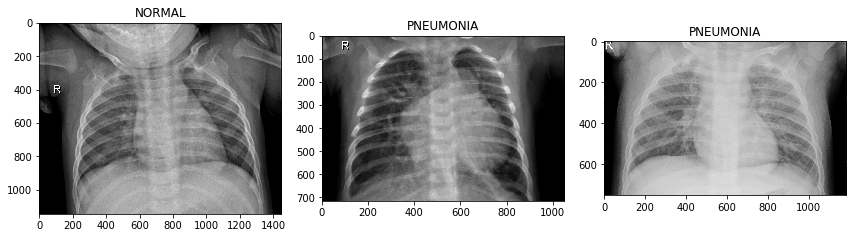

In [5]:
img_normal = plt.imread('./data/chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('./data/chest_xray/train/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread('./data/chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

Illustrative examples of Chest X-Rays in patients with pneumonia

- normal chest X-ray (left) depicts clear lungs without any areas of abnormal opacification in the image
- bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the left lobe
- viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs

We're going to write a function that maps image path to class:
- 0 = NORMAL
- 1 = PNEUMONIA

In [0]:
def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [7]:
x, y = get_labeled_files('./data/chest_xray/train/')

list(zip(x, y))[:10]

[('./data/chest_xray/train/NORMAL/NORMAL2-IM-0554-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0659-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0923-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0507-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0819-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0419-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0391-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0832-0001-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0469-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-1067-0001.jpeg', 0)]

Before we start working with the images need to peform a little of preprocessing, i.e. 
- read the image into an array (3 color channels)
- resize the image to 150px x 150px 
- one hot encode image lables

We are composing the transformations using Tensorflow data pipeline. 

In [0]:
NUM_CLASSES = 2

# This function takes image paths as arguments and reads corresponding images
def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)
    # read the img from file and decode it using tf
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_file, channels=3, name="decoded_images")
    return img_decoded, one_hot

# This function takes image and resizes it to smaller format (150x150)
def image_resize(images, labels):
    # Be very careful with resizing images like this and make sure to read the doc!
    # Otherwise, bad things can happen - https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
    resized_image = tf.image.resize_images(images, (150, 150), align_corners=True)
    resized_image_asint = tf.cast(resized_image, tf.int32)
    return resized_image_asint, labels    

In [0]:
# Execution plan is defined here.
# Since it uses lazy evaluation, the images will not be read after calling build_pipeline_plan()
# We need to use iterator defined here in tf context
def build_pipeline_plan(img_paths, labels, batch_size):

    # We build a tensor of image paths and labels
    tr_data = Dataset.from_tensor_slices((img_paths, labels))
    # First step of input pipeline - read images in paths as jpegs
    tr_data_imgs = tr_data.map(input_parser)
    # Apply resize to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_resize)
    # Gives us opportuinty to batch images into small groups
    tr_dataset = tr_data_imgs.batch(batch_size)
    # create TensorFlow Iterator object directly from input pipeline
    iterator = tr_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element

# Function to execute defined pipeline in Tensorflow session
def process_pipeline(next_element):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # get each element of the training dataset until the end is reached
        # in our case only one iteration since we read everything as 1 batch
        # can be multiple iterations if we decrease BATCH_SIZE to eg. 10
        images = []
        labels_hot = []
        while True:
            try:
                elem = sess.run(next_element)
                images = elem[0]
                labels_hot = elem[1]
            except tf.errors.OutOfRangeError:
                print("Finished reading the dataset")
                return images, labels_hot

In [0]:
def load_dataset(path, batch_size):
    tf.reset_default_graph()
    files, labels = get_labeled_files(path)
    p = tf.constant(files, name="train_imgs")
    l = tf.constant(labels, name="train_labels")
    
    next_element = build_pipeline_plan(p, l, batch_size=batch_size)
    imgs, labels = process_pipeline(next_element)
    return imgs, labels

Now, we're going to load load the data (train, test and validation) into separate variables

In [11]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)
x_val, y_val = load_dataset("./data/chest_xray/val/", 6000)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Finished reading the dataset
Finished reading the dataset
Finished reading the dataset


Let's check the shape of the data structures. All images are 150px x 150px with three color channels.

In [12]:
print(x_train.shape)
print(y_train.shape)

(5216, 150, 150, 3)
(5216, 2)


Target variable is One-hot encoded 

In [13]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

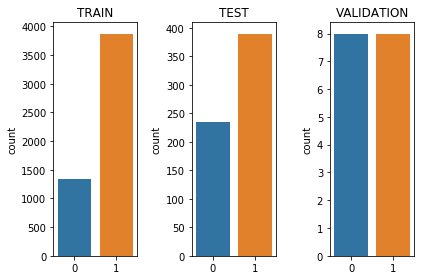

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.subplot(1,3,1)
sns.countplot(np.argmax(y_train, axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.subplot(1,3,3)
sns.countplot(np.argmax(y_val, axis=1)).set_title('VALIDATION')

plt.tight_layout()

Our datasets are **imbalanced**. We see more examples with **PNEUMONIA** x-ray images

In [0]:
#only use in Jupyter notebook
#from ipynb.fs.defs.p1_data_prep import load_dataset

In [17]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)

Finished reading the dataset
Finished reading the dataset


(5216, 150, 150, 3)


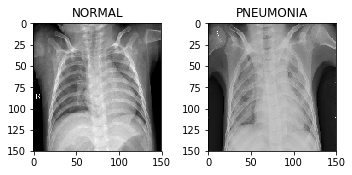

In [18]:
print(x_train.shape)

plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(y_train, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train_classes == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train_classes == 1)])

plt.tight_layout()

In [19]:
#We're going to load VGG16 model with pre-trained ImageNet weights.
K.clear_session()

NUM_CLASSES = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)     

This network has over 14M trainable weights.

In [0]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [21]:
#We would like to train only the most bottom classifier layers.
for layer in model.layers[0:20]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: False
layer 20: dense_1, trainable: True


In [22]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(8192, 2) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32_ref>]

In [23]:
optimizer = keras.optimizers.RMSprop()

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=False, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

In [25]:
#The training set is un-balanaced. Let's calculate class weights
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [26]:
# prepare a directory to store the model weights
os.makedirs('./model', exist_ok=True)

history = model.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[checkpoint, tensorboard],
    shuffle=True,
    batch_size=64,
    epochs=20,
    verbose=1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3651 samples, validate on 1565 samples


Epoch 1/20
3651/3651 [==============================] - 30s 8ms/step - loss: 1.4463 - acc: 0.8852 - val_loss: 2.7143 - val_acc: 0.7968

Epoch 00001: saving model to model/weights.epoch_01.hdf5
Epoch 2/20
3651/3651 [==============================] - 24s 7ms/step - loss: 0.5075 - acc: 0.9573 - val_loss: 0.6134 - val_acc: 0.9521

Epoch 00002: saving model to model/weights.epoch_02.hdf5
Epoch 3/20
3651/3651 [==============================] - 24s 7ms/step - loss: 0.4559 - acc: 0.9617 - val_loss: 0.5833 - val_acc: 0.9521

Epoch 00003: saving model to model/weights.epoch_03.hdf5
Epoch 4/20
3651/3651 [==============================] - 24s 7ms/step - loss: 0.4249 - acc: 0.9652 - val_loss: 0.2443 - val_acc: 0.9796

Epoch 00004: saving model to model/weights.epoch_04.hdf5
Epoch 5/20
3651/3651 [==============================] - 24s 7ms/step - loss: 0.3469 

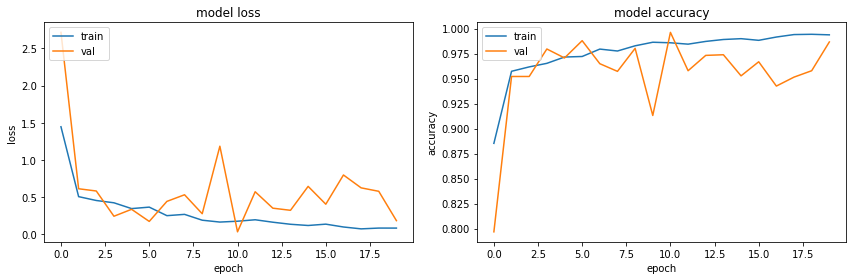

In [27]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

In [28]:
idx = np.argmin(history.history['val_loss']) 
#model.load_weights("model/weights.epoch_{:02d}.hdf5".format(idx + 1))

print("Loading the best model")
print("epoch: {}, val_loss: {}, val_acc: {}".format(idx + 1, history.history['val_loss'][idx], history.history['val_acc'][idx]))

Loading the best model
epoch: 11, val_loss: 0.03488473086065475, val_acc: 0.9961661341853035


In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 3.0995743159119624, Accuracy: 0.7900641025641025


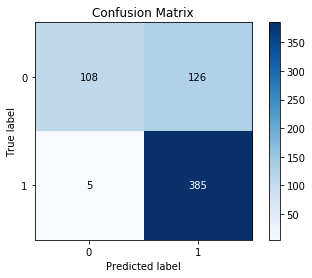

In [30]:
y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
skplt.metrics.plot_confusion_matrix(y_true, y_pred_classes, normalize=False)

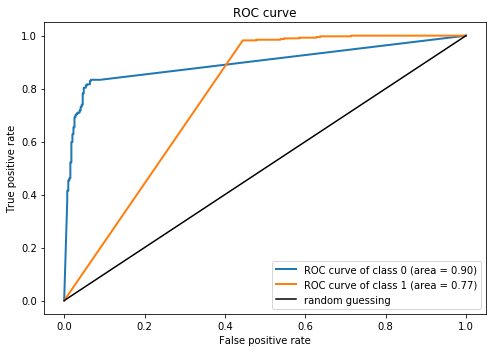

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

(468, 67500)
(468,)
(468, 150, 150, 3)
(468, 2)


Text(0.5, 1.0, 'TEST (undersampled)')

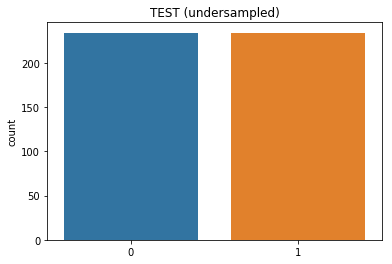

In [32]:
#Performing undersampling to see, if it improves training
rus = RandomUnderSampler(random_state=42)

x_test_flat_shape = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
x_test_flat = x_test.reshape(x_test.shape[0], x_test_flat_shape)

y_test_flat = np.argmax(y_test, axis=1)

x_res, y_res = rus.fit_resample(x_test_flat, y_test_flat)

print(x_res.shape)
print(y_res.shape)

y_test_rus = to_categorical(y_res, num_classes = 2)

for i in range(len(x_res)):
    height, width, channels = 150, 150, 3
    x_test_rus = x_res.reshape(len(x_res), height, width, channels)
    
print(x_test_rus.shape)
print(y_test_rus.shape)

sns.countplot(np.argmax(y_test_rus, axis=1)).set_title('TEST (undersampled)')

In [33]:
score = model.evaluate(x_test_rus, y_test_rus, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 4.0983253367181565, Accuracy: 0.7222222222222222


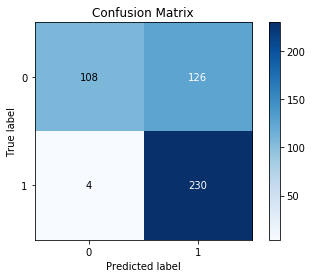

In [34]:
y_pred = model.predict(x_test_rus)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test_rus, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
skplt.metrics.plot_confusion_matrix(y_true, y_pred_classes, normalize=False)

It appears that the imbalanced data set created better predictions than the balanced dataset, but the balanced dataset is a better test.  The model might have been biased towards healthy images to guess better in that direction.